## Simple damped harmonic oscillator

This example notebook characterizes the slimplectic Galerkin-Gauss-Lobatto variational integrator with the simple damped harmonic oscillator, which has a known analytical solution. 

The conservative part $L$ of the total Lagrangian $\Lambda$ is
$$L = \frac{1}{2} m \dot{q}^2 - \frac{1}{2} k q^2$$
and the nonconservative part $K$ is
$$K = - \lambda \dot{q}_+ q_- \, .$$
The known analytical solution to the equations of motion is
$$q(t) = q(0)e^{-\lambda t/ 2} \cos \left( \Omega t + \phi(0) \right)$$ 
where 
$$\Omega = \sqrt{ \frac{k}{m} - \frac{\lambda^2 }{ 4} }$$
and the initial velocity $\dot{q}(0)$ is related to $\phi(0)$ through
$$\dot{q}(0) = - q(0) \left( \frac{ \lambda}{2} \cos \phi(0) + \Omega \sin \phi(0) \right).$$

In this notebook, we take $\lambda = 10^{-4}\sqrt{m k}$ though other choices are possible, of course. 

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
import jax.numpy as jnp
from slimpletic import Solver

In [2]:
# Set harmonic oscillator parameters
m = 1.0
k = 1.0
ll = 1e-4 * np.sqrt(m * k)  # ll is $\lambda$ in the paper

### Slimplectic integration

In [11]:
def lagrangian(q, v, t):
    """Simple damped harmonic oscillator Lagrangian"""
    return 0.5 * m * jnp.dot(v, v) - 0.5 * k * jnp.dot(q, q)


def nonconservative(qp, qm, vp, vm, t):
    """Nonconservative part of the Lagrangian"""
    return -ll * jnp.dot(vp, qm)

In [8]:
# Specify time samples at which the numerical solution is to be given initial data

# Time samples
dt = 0.1 * np.sqrt(m / k)
tmax = 10000 * np.sqrt(m / k)
t = dt * np.arange(0, int(tmax / dt) + 1)

# Initial data (at t=0)
q0 = jnp.array([1.])
pi0 = jnp.array([0.25 * dt * k])
# The initial condition for pi0 is chosen because the 2nd order slimplectic method 
# has $\pi$ actually evaluated at the mid-step, and it needs corrections to that effect.
# Otherwise, the phase is off and the energy has a constant offset. 

In [12]:
# Create an instance of the GalerkinGaussLobatto class and call it `dho` for damped harmonic oscillator.
dho_2 = Solver(
    r=0,
    dt=dt,
    lagrangian=lagrangian, k_potential=nonconservative
)

In [13]:
# Now integrate the 2nd order slimplectic integrator
q_slim2, pi_slim2 = dho_2.integrate(q0, pi0, t0=0, t_sample_count=t.size)

In [14]:
dho_4 = Solver(
    r=1,
    dt=dt,
    lagrangian=lagrangian, k_potential=nonconservative
)

q_slim4, pi_slim4 = dho_4.integrate(q0, pi0=jnp.array([0.]), t0=0, t_sample_count=t.size)

### Runge-Kutta integration

Generate the 2nd and 4th order Runge-Kutta solutions to compare below with output from the slimplectic integrators.

In [21]:
##########################################
# Class for 4th order Runge-Kutta method #
##########################################

class RungeKutta4(object):

    def __init__(self):
        self._b = np.array([1. / 6., 1. / 3., 1. / 3., 1. / 6.])
        self._k = [[], [], [], []]

    def _iter(self, tn, yn_list, f, h):
        self._k[0] = f(tn, yn_list)
        self._k[1] = f(tn + h / 2., yn_list + h / 2. * self._k[0])
        self._k[2] = f(tn + h / 2., yn_list + h / 2. * self._k[1])
        self._k[3] = f(tn + h, yn_list + h * self._k[2])
        return yn_list + h * np.sum(self._b[ii] * self._k[ii] for ii in range(4))

    def integrate(self, q0_list, v0_list, t, f):
        y0_list = np.hstack([q0_list, v0_list])
        h = t[1] - t[0]
        ans = np.zeros((t.size, len(y0_list)))
        ans[0, :] = y0_list
        for ii, tt in enumerate(t[:-1]):
            ans[ii + 1, :] = self._iter(tt, ans[ii], f, h)
        out = ans.T
        return out[:len(q0_list)], out[len(q0_list):]

    def __call__(self, q0, v0, t, f):
        return self.integrate(q0, v0, t, f)


##########################################
# Class for 2nd order Runge-Kutta method #
##########################################

class RungeKutta2(object):

    def __init__(self):
        self._b = np.array([0., 1.])
        self._k = [[], []]

    def _iter(self, tn, yn_list, f, h):
        self._k[0] = f(tn, yn_list)
        self._k[1] = f(tn + h / 2., yn_list + h / 2. * self._k[0])
        return yn_list + h * np.sum(self._b[ii] * self._k[ii] for ii in range(2))

    def integrate(self, q0_list, v0_list, t, f):
        y0_list = np.hstack([q0_list, v0_list])
        h = t[1] - t[0]
        ans = np.zeros((t.size, len(y0_list)))
        ans[0, :] = y0_list
        for ii, tt in enumerate(t[:-1]):
            ans[ii + 1, :] = self._iter(tt, ans[ii], f, h)
        #return ans.T
        out = ans.T
        return out[:len(q0_list)], out[len(q0_list):]

    def __call__(self, q0, v0, t, f):
        return self.integrate(q0, v0, t, f)

In [22]:
# Instantiate the 2nd and 4th order Runge-Kutta classes
rk2 = RungeKutta2()
rk4 = RungeKutta4()


# Define the derivative operator for a simple damped harmonic oscillator
def dydt(time, y):
    deriv = np.zeros(2)
    [q_x, v_x] = y
    deriv[0] = v_x
    deriv[1] = - (k / m) * q_x - (ll / m) * v_x
    return deriv


# Integrate
v0 = [0.]
q_rk2, v_rk2 = rk2.integrate(q0, v0, t, dydt)
q_rk4, v_rk4 = rk4.integrate(q0, v0, t, dydt)

# Please note that q and pi are outputs of the slimplectic integration, 
# while q and v are output from the Runge-Kutta integrators.

/var/folders/7t/7cmj88216yq46yv_dg9r448w0000gn/T/ipykernel_9435/3642982292.py:45: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return yn_list + h * np.sum(self._b[ii] * self._k[ii] for ii in range(2))
/var/folders/7t/7cmj88216yq46yv_dg9r448w0000gn/T/ipykernel_9435/3642982292.py:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return yn_list + h * np.sum(self._b[ii] * self._k[ii] for ii in range(4))


### Comparison plots

Plot the oscillator amplitude $q(t)$ for the 2nd and 4th order slimplectic and RK integrators along with the analytical solution.

In [23]:
# Analytical solution
Omega = np.sqrt(k / m - ll ** 2 / 4.)
phi0 = - np.arctan(-ll / (2. * Omega))


def q(time):
    """Analytical solution for simple damped harmonic oscillator amplitude with q0=1, v0=0"""
    return np.exp(-ll * time / 2.) * np.cos(Omega * time + phi0)


def v(time):
    """Analytical solution for simple damped harmonic oscillator velocity with q0=1, v0=0"""
    return np.exp(-ll * time / 2.) * (-ll / 2. * np.cos(Omega * time + phi0) - Omega * np.sin(Omega * time + phi0))

In [25]:
q_slim2

Array([1.        , 0.99750001, 0.9850251 , ..., 0.21121835, 0.15335546,
       0.09395959], dtype=float64)

Text(0, 0.5, 'Oscillator Amplitude, $q$')

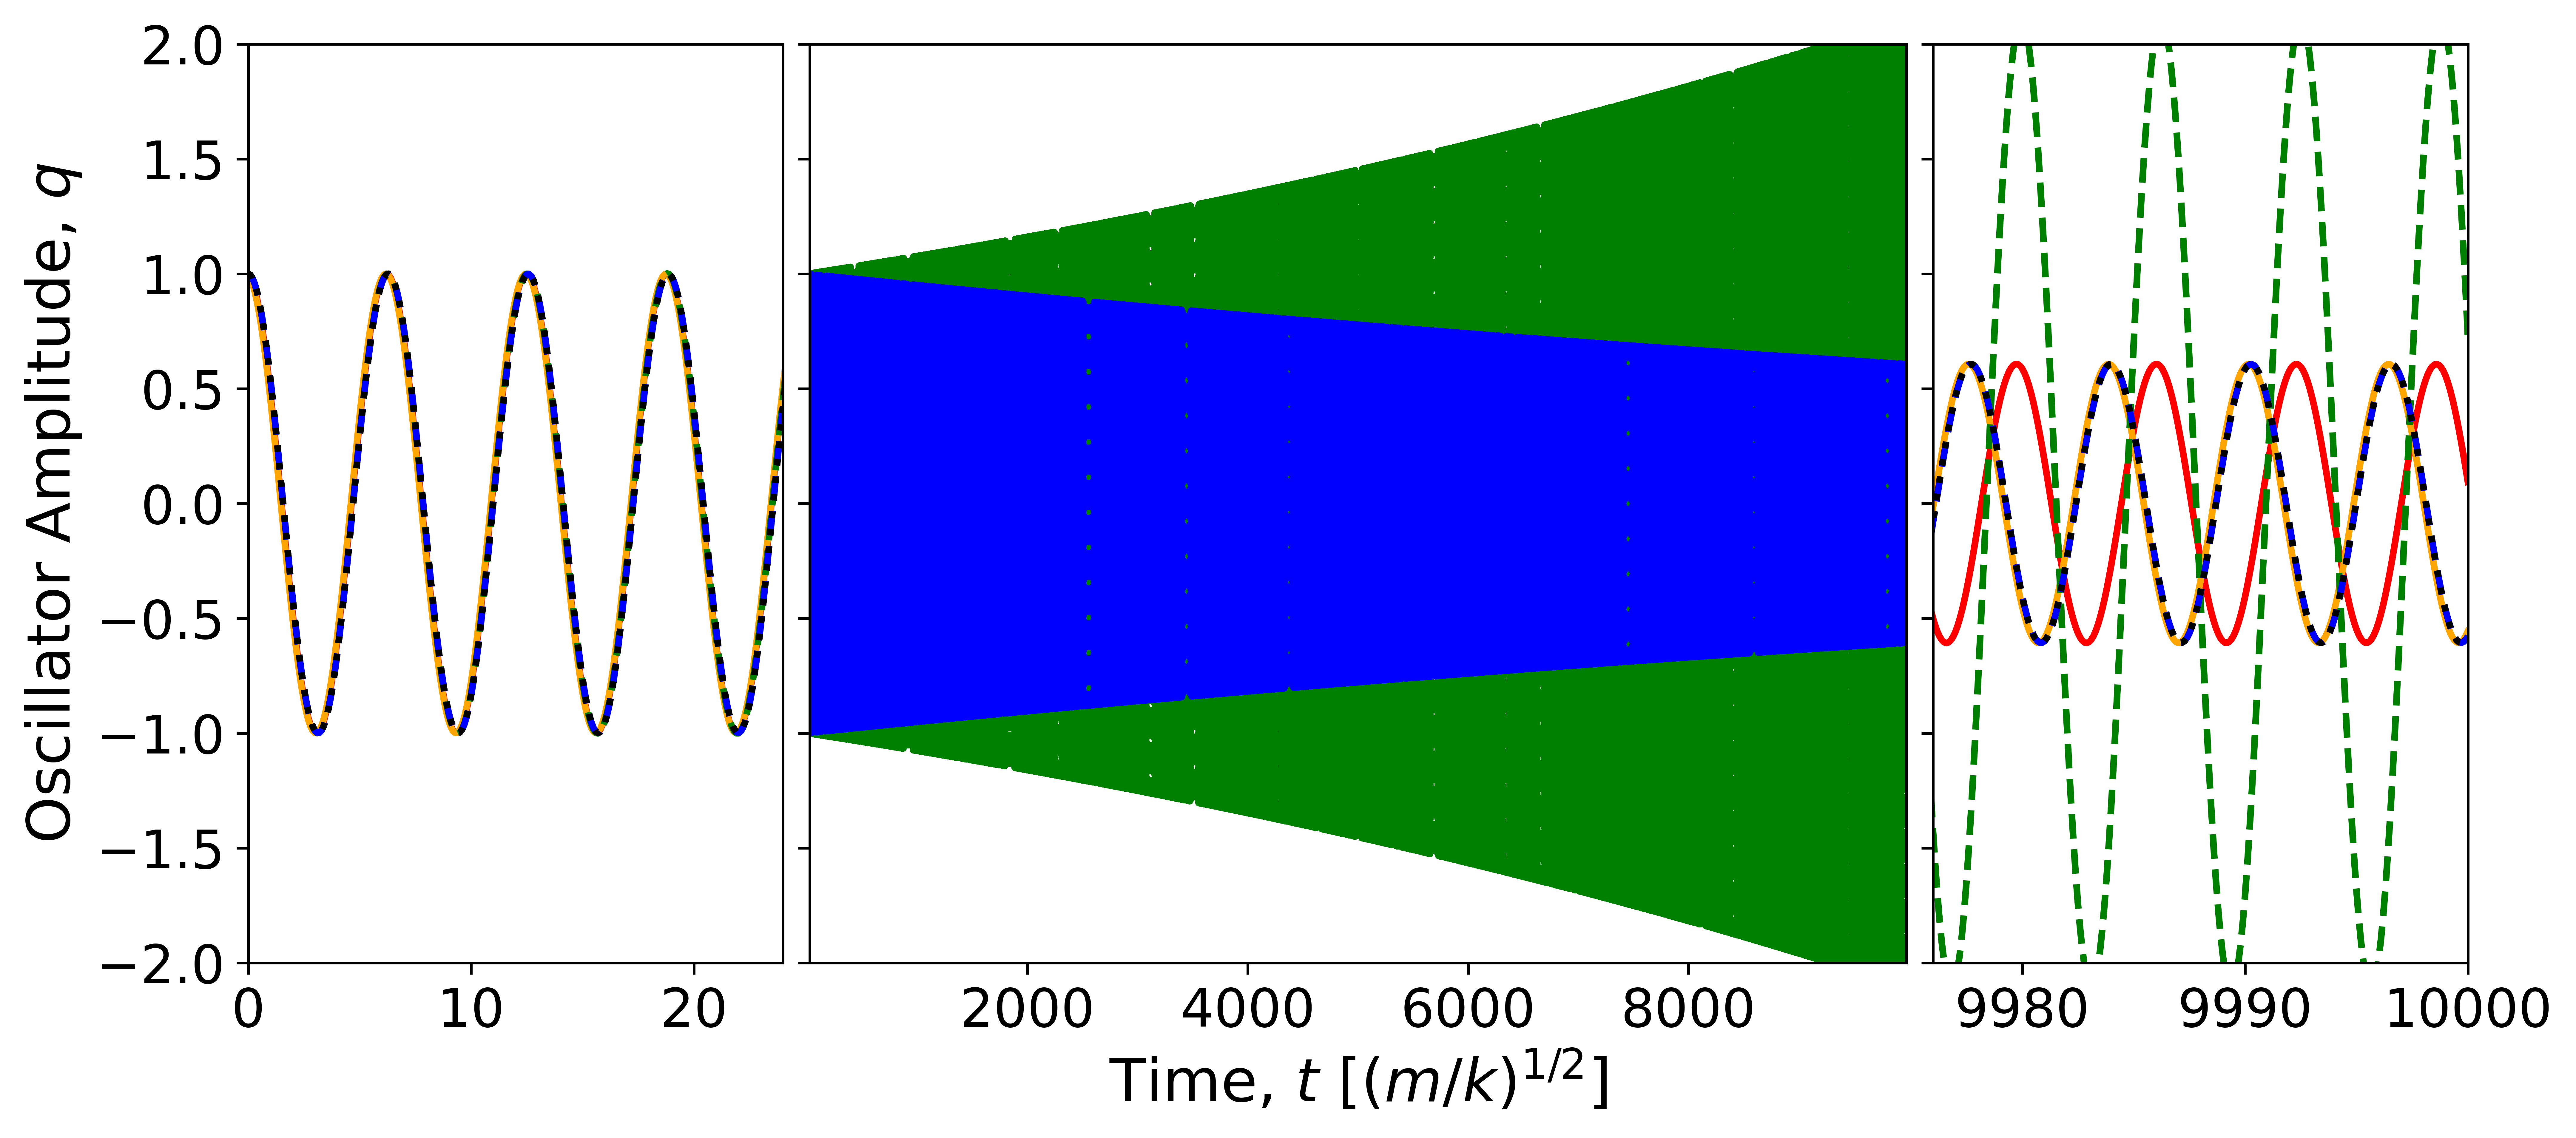

In [28]:
fig1 = plt.figure(figsize=(12, 5), dpi=800)
fig1.subplots_adjust(wspace=0.05)

# Early times...
ax1a = fig1.add_subplot(1, 4, 1)
ax1a.set_ylim(-2, 2)
ax1a.set_xlim(0, 24)
ax1a.plot(t, q_slim2[1:], 'r-', linewidth=2.0, rasterized=True)
ax1a.plot(t, q_slim4[1:], color='orange', linewidth=2.0, rasterized=True)
ax1a.plot(t, q_rk2[0], 'g--', linewidth=2.0, rasterized=True)
ax1a.plot(t, q_rk4[0], 'b--', linewidth=2.0, rasterized=True)
ax1a.plot(t, q(t), 'k:', linewidth=2.0, rasterized=True)

# Middle times...
ax1b = fig1.add_subplot(1, 4, (2, 3))
plt.setp(ax1b.get_yticklabels(), visible=False)
ax1b.set_ylim(-2, 2)
ax1b.set_xlim(24.9, 9975.9)
ax1b.plot(t, q_slim2[1:], linewidth=2.0, linestyle='-', color='red', rasterized=True)
ax1b.plot(t, q_slim4[1:], linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax1b.plot(t, q_rk2[0], linewidth=2.0, linestyle='--', color='g', rasterized=True)
ax1b.plot(t, q_rk4[0], linewidth=2.0, linestyle='--', color='blue', rasterized=True)

# Late times...
ax1c = fig1.add_subplot(1, 4, 4)
plt.setp(ax1c.get_yticklabels(), visible=False)
ax1c.set_ylim(-2, 2)
ax1c.set_xlim(9976, 10000)
ax1c.plot(t, q_slim2[1:], linewidth=2.0, linestyle='-', color='red', rasterized=True)
ax1c.plot(t, q_slim4[1:], linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax1c.plot(t, q_rk2[0], linewidth=2.0, linestyle='--', color='g', rasterized=True)
ax1c.plot(t, q_rk4[0], linewidth=2.0, linestyle='--', color='blue', rasterized=True)
ax1c.plot(t, q(t), 'k:', linewidth=2.0, rasterized=True)

ax1a.tick_params(axis='both', which='major', labelsize=16)
ax1b.tick_params(axis='both', which='major', labelsize=16)
ax1c.tick_params(axis='both', which='major', labelsize=16)
ax1c.set_xticks([9980, 9990, 10000])

ax1b.set_xlabel('Time, $t$ [$(m/k)^{1/2}$]', fontsize=18)
ax1a.set_ylabel('Oscillator Amplitude, $q$', fontsize=18)

In [ ]:
#fig1.savefig("plot_path" + "DampSimpleCombined.pdf", transparent=True,bbox_inches='tight', dpi=500)

Let's see how the oscillator's energy changes with time according to the different orders and integration schemes. The energy is
$$E = \frac{1}{2} m \dot{q}^2 + \frac{1}{2} k q^2$$
and changes in time according to
$$\frac{ dE}{dt} = - \lambda \dot{q}^2.$$

To quantify the errors incurred by discretization and subsequent numerical integration, we define the fractional or relative energy difference as $\delta E / E = ( E_X - E )/ E$ where $E_X$ is the energy as measured by integrator $X$ with $X \in \{ {\rm Slim2,~Slim4,~RK2,~RK4} \}$.

In [31]:
# Energy function
def Energy(q, v):
    return 0.5 * m * v ** 2 + 0.5 * k * q ** 2


# Energies from the analytic solution and from different integrators
E = Energy(q(t), v(t))

E_slim2 = Energy(q_slim2, pi_slim2 / m)
E_slim4 = Energy(q_slim4, pi_slim4 / m)

E_rk2 = Energy(q_rk2[0], v_rk2[0])
E_rk4 = Energy(q_rk4[0], v_rk4[0])

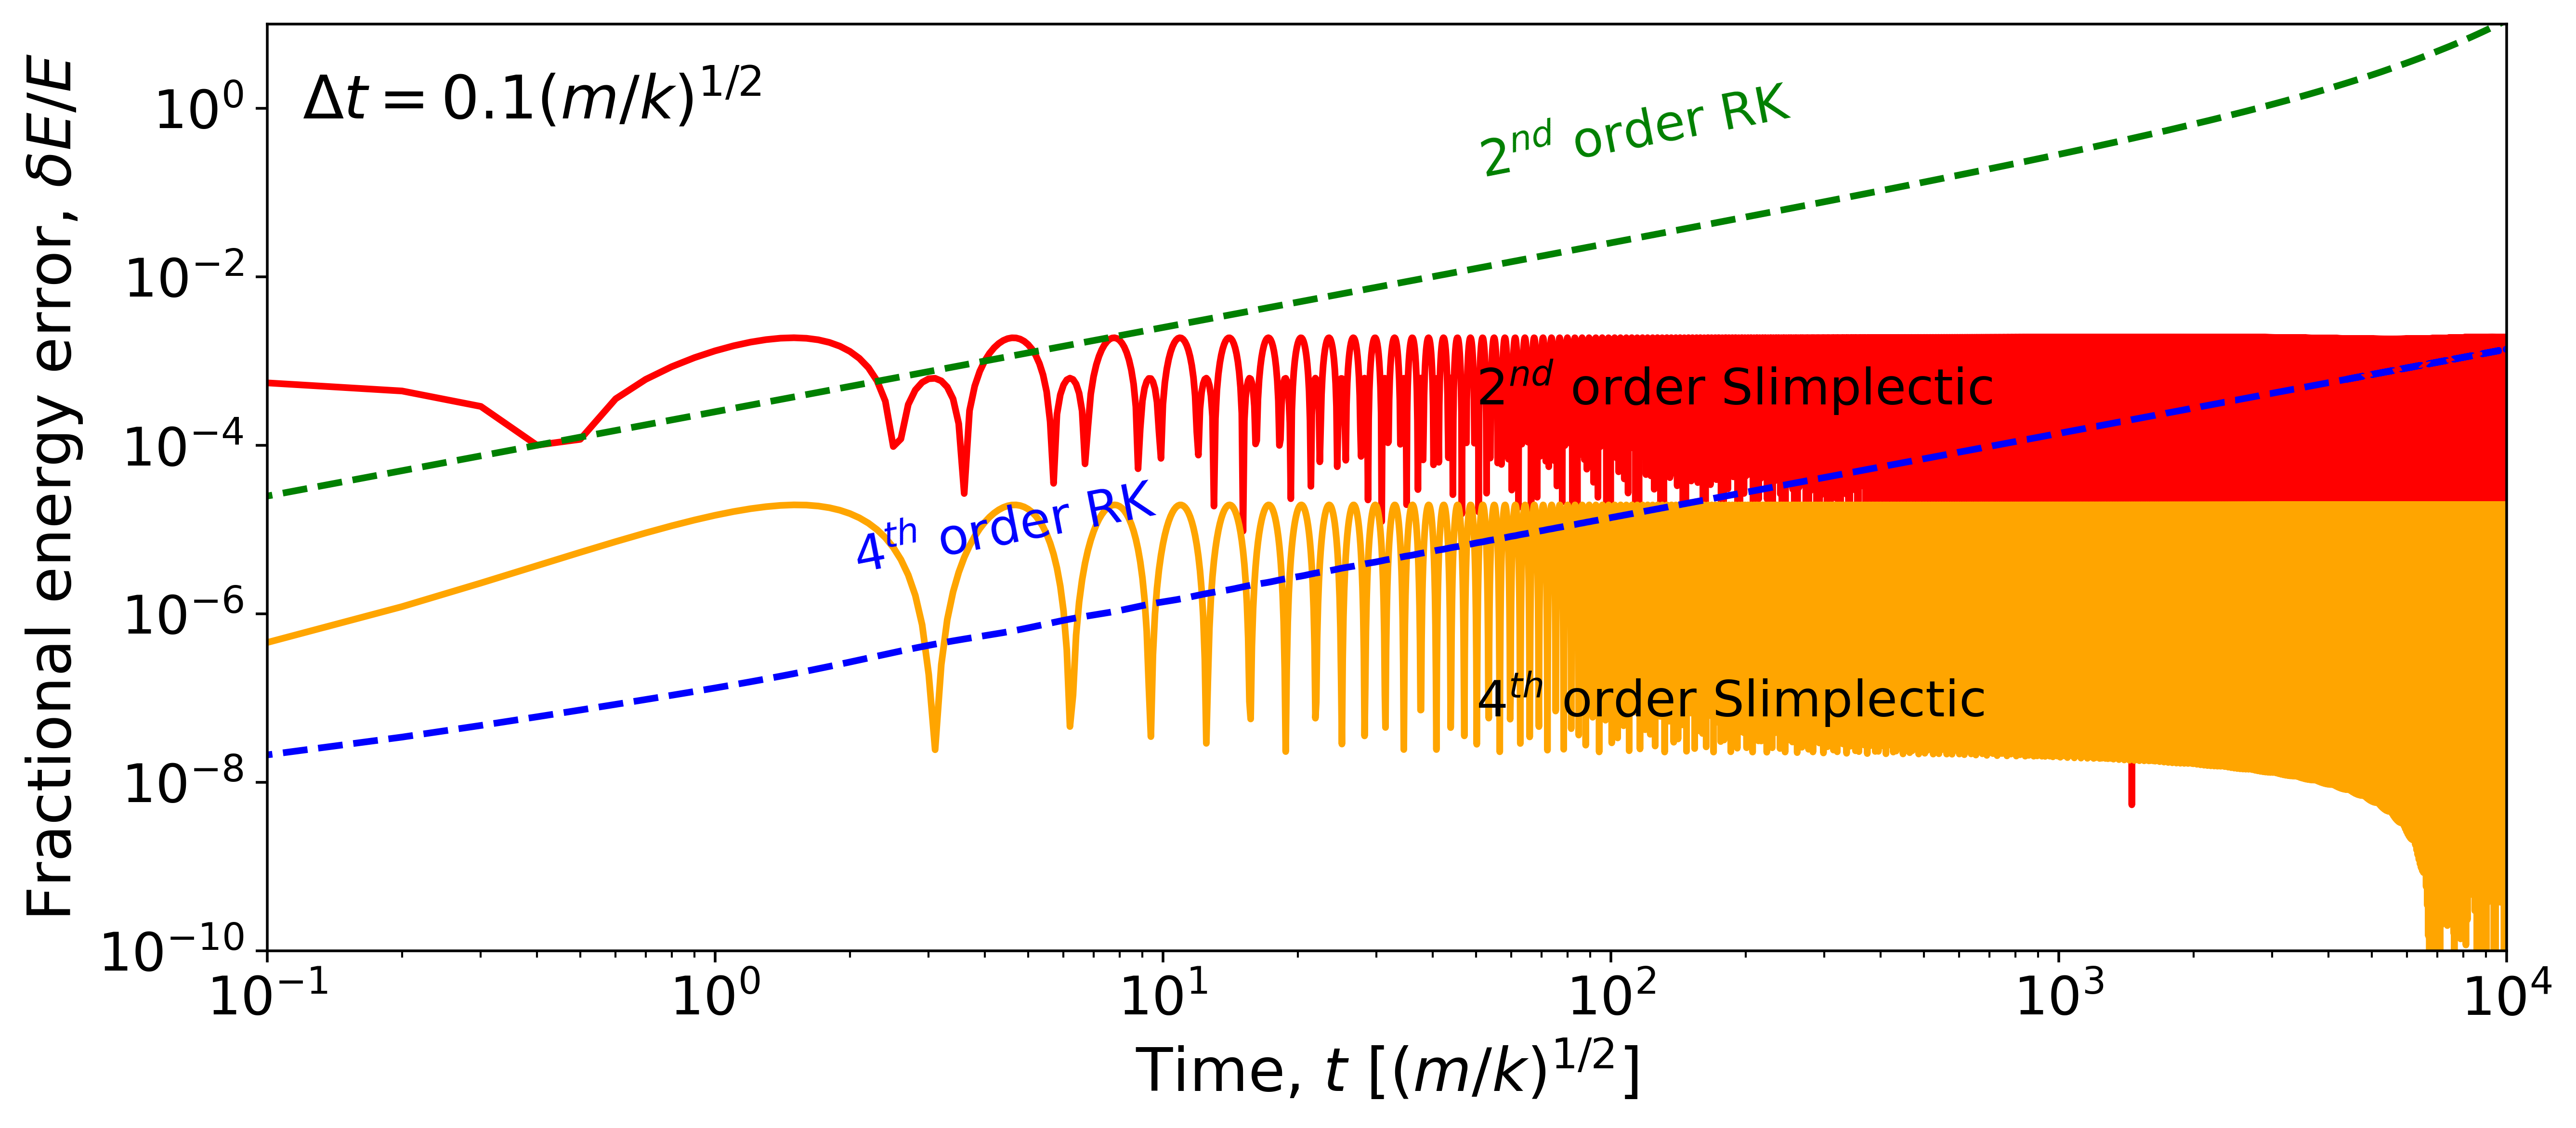

In [33]:
fig2 = plt.figure(figsize=(12, 5), dpi=500)

ax2 = fig2.add_subplot(1, 1, 1)
ax2.set_ylim(1e-10, 1e1)
ax2.set_xlim(0.1, 10000)

ax2.loglog(t, np.abs(E_slim2[1:] / E - 1.), 'r-', linewidth=2.0, rasterized=True)
ax2.loglog(t, np.abs(E_slim4[1:] / E - 1.), color='orange', linestyle='-', linewidth=2.0, rasterized=True)
ax2.loglog(t, np.abs(E_rk2 / E - 1.), 'g--', linewidth=2.0, rasterized=True)
ax2.loglog(t, np.abs(E_rk4 / E - 1.), 'b--', linewidth=2.0, rasterized=True)

ax2.set_xlabel('Time, $t$ [$(m/k)^{1/2}$]', fontsize=18)
ax2.set_ylabel('Fractional energy error, $\delta E/E$', fontsize=18)

ax2.text(0.12, 0.75, r'$\Delta t = 0.1 (m/k)^{1/2}$', fontsize=18, color='k')
ax2.text(50, 3e-4, r'$2^{nd}$ order Slimplectic', fontsize=15, color='k')
ax2.text(50, 6e-8, r'$4^{th}$ order Slimplectic', fontsize=15, color='black')
ax2.text(2, 3e-6, r'$4^{th}$ order RK', fontsize=15, color='b', rotation=11)
ax2.text(50, 1.5e-1, r'$2^{nd}$ order RK', fontsize=15, color='g', rotation=11)

ax2.tick_params(axis='both', which='major', labelsize=16)

In [ ]:
#fig2.savefig(plot_path + "DampSimpleELog.pdf", transparent=True,bbox_inches='tight', dpi=300)